# Customer Segmentation (Clustering - RFM Analysis)

## 1. Data Cleaning and Preparation

In [1]:
# Import libraries
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from mpl_toolkits.mplot3d import Axes3D
from math import pi
# from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

---

In [2]:
# Load dataset
data = pd.read_csv('../data/online_retail.csv').copy()
print(f'Rows, Columns count', data.shape)
data.head()

Rows, Columns count (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


**1. Data Inspection**

In [3]:
# Descriptive summary of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


- 2 columns have missing values;`Description` and `CustomerID`, 
- `InvoiceDate` needs to be converted to datetime object and `CustomerID` to category type to use it as a transaction identifier. 
- Since `CustomerID` is a critical column there aren't quite many of Null values, we can drop the NaNs in our dataframe.
- We'll be converting all objects to category datatype.

1. Handling Missing Data & Categorical Data

In [4]:
# Handling datatypes and Missing values
print("Missing Values:\n", data.isna().sum())
# Check for and drop missing values for critical columns
data.dropna(subset=['InvoiceNo', 'CustomerID', 'InvoiceDate'], inplace=True)
# Normalize case
data['Description'] = data['Description'].str.lower()
# Convert customerID to str
data['CustomerID'] = data['CustomerID'].astype(int).astype(str)

# Convert categorical columns to strings stripping
cat_cols = ['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Country']
# # Normalize case
# data[cat_cols] = data[cat_cols].apply(lambda col: col.str.lower(), axis=1)

# Clean categorical columns
for col in cat_cols:
    # Convert to string, handle nulls, and strip whitespaces
    data[col] = data[col].astype(str).fillna('missing').str.replace(r'\s+', ' ', regex=True).str.strip()

# Convert str back to category datatype
data[cat_cols] = data[cat_cols].astype('category')

# Inspection check
print(data.dtypes)

Missing Values:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
InvoiceNo      category
StockCode      category
Description    category
Quantity          int64
InvoiceDate      object
UnitPrice       float64
CustomerID     category
Country        category
dtype: object


2. Handling Date Column (InvoiceDate) and Creating Derived Columns

In [5]:
# Change invoiceDate to DateTime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], errors='coerce')

# Create column for Canceled orders and perform filtering. (1= canceled order, 0 = valid order)
data['is_canceled'] = data['InvoiceNo'].str.startswith('C').astype(int)

# Create a new column to indicate free promotional items based on UnitPrice == 0.00
data['is_free_promo'] = (data['UnitPrice'] == 0).astype(int)

# Create TransactionAmount columns
data['InvoiceAmount'] = (data['UnitPrice'] * data['Quantity'])

free_promo = data[data['is_free_promo'] == 1].copy().reset_index(drop=True)  # Free promotional items
valid_orders = data[data['is_canceled'] == 0].copy().reset_index(drop=True) #data[(data['is_canceled'] == 0) & (data['InvoiceAmount'] > 0)] # Exta condition to avoid double counting
canceled_orders = data[data['is_canceled'] == 1].copy().reset_index(drop=True)
# Inspection check:
# count of free promotional items
# print(f"Number of free promotional items: {data['is_free_promo'].sum()}")
# print(f'Updated Rows, Columns:', data.shape)
print(data.shape)
print(free_promo.shape)
print(valid_orders.shape)
print(canceled_orders.shape)

(406829, 11)
(40, 11)
(397924, 11)
(8905, 11)


In [6]:
print(valid_orders['InvoiceNo'].isna().sum())  # Check for NaNs in valid_orders
print(canceled_orders['InvoiceNo'].isna().sum())  # Check for NaNs in canceled_orders

0
0


In [7]:
valid_orders.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'is_canceled', 'is_free_promo',
       'InvoiceAmount'],
      dtype='object')

In [8]:
valid_orders['InvoiceNo'].value_counts()

InvoiceNo
576339     542
579196     533
580727     529
578270     442
573576     435
          ... 
C550530      0
C550533      0
C550534      0
C550536      0
C581569      0
Name: count, Length: 22190, dtype: int64

In [9]:
print("Unique InvoiceNo in original data:", data['InvoiceNo'].nunique())
print("Unique InvoiceNo in valid_orders:", valid_orders['InvoiceNo'].nunique())
print("Unique InvoiceNo in canceled_orders:", canceled_orders['InvoiceNo'].nunique())
len(data['InvoiceNo'])  == len(valid_orders['InvoiceNo']) + len(canceled_orders['InvoiceNo'])

Unique InvoiceNo in original data: 22190
Unique InvoiceNo in valid_orders: 18536
Unique InvoiceNo in canceled_orders: 3654


True

In [10]:
print(len(valid_orders['InvoiceNo']))
print(len(canceled_orders['InvoiceNo']))
print(len(data['InvoiceNo']))

397924
8905
406829


2. Handling Duplicate Entries

In [11]:
print(f'Duplicate Entries: ', data.duplicated().sum()) # 5192 Duplicates
duplicates = data[data.duplicated()]
print(len(duplicates))
duplicates.value_counts()

Duplicate Entries:  5225
5225


InvoiceNo  StockCode  Description                          Quantity  InvoiceDate          UnitPrice  CustomerID  Country         is_canceled  is_free_promo  InvoiceAmount
555524     22698      pink regency teacup and saucer        1        2011-06-05 11:37:00  2.95       16923       United Kingdom  0            0               2.95            19
           22697      green regency teacup and saucer       1        2011-06-05 11:37:00  2.95       16923       United Kingdom  0            0               2.95            11
572861     22775      purple drawerknob acrylic edwardian   12       2011-10-26 12:46:00  1.25       14102       United Kingdom  0            0               15.00            7
572344     M          manual                                48       2011-10-24 10:43:00  1.50       14607       United Kingdom  0            0               72.00            5
540524     21756      bath building block word              1        2011-01-09 12:53:00  5.95       16735       United K

The duplicated entries appear to be multiple purchases of an item made by a customer, we will leave them as they are. Might be useful in getting customer-spending computations.

3. Inspecting summary statistics of numerical columns

In [12]:
# Statistical summary for numerical columns
data.describe(include='number')

,Quantity,UnitPrice,is_canceled,is_free_promo,InvoiceAmount
count,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,0.021889,0.000098,20.401854
std,248.693370,69.315162,0.146321,0.009915,427.591718
min,-80995.000000,0.000000,0.000000,0.000000,-168469.600000
25%,2.000000,1.250000,0.000000,0.000000,4.200000
50%,5.000000,1.950000,0.000000,0.000000,11.100000
75%,12.000000,3.750000,0.000000,0.000000,19.500000
max,80995.000000,38970.000000,1.000000,1.000000,168469.600000


There's `skewness` in our numerical columns

In [13]:
print(data[['Quantity', 'InvoiceAmount']].skew())

Quantity         0.182663
InvoiceAmount   -0.056982
dtype: float64


Handling Outliers of Numerical Columns. 

We have several groups within your dataset:

- Valid Orders: These are the standard transactions with normal positive values for Quantity and InvoiceAmount.
- Canceled Orders: These orders have negative or zero values due to cancellations. This group should be treated separately.
- Free Promotional Items: These have UnitPrice == 0.00 and might be either part of valid orders or separate special transactions.

In [14]:
# Valid Orders Group:
# Handling Outliers and Skewness(Log-transform)
valid_orders['log_InvoiceAmount'] = np.log1p(valid_orders['InvoiceAmount'] + 1e-9)
valid_orders['log_Quantity'] = np.log1p(valid_orders['Quantity'] + 1e-9)

# Capping values in valid orders based on percentiles
cap_invoice_amount = valid_orders['InvoiceAmount'].quantile(0.99)
cap_quantity = valid_orders['Quantity'].quantile(0.99)

valid_orders['InvoiceAmount'] = valid_orders['InvoiceAmount'].clip(upper=cap_invoice_amount)
valid_orders['Quantity'] = valid_orders['Quantity'].clip(upper=cap_quantity)

# Q1 = valid_orders[['InvoiceAmount', 'Quantity']].quantile(0.25)
# Q3 = valid_orders[['InvoiceAmount', 'Quantity']].quantile(0.75)
# IQR = Q3 - Q1
# valid_orders = valid_orders[~((valid_orders[['InvoiceAmount', 'Quantity']] < (Q1 - 1.5 * IQR)) | 
#                               (valid_orders[['InvoiceAmount', 'Quantity']] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Canceled Orders:
# Masking negative values for canceled orders
canceled_orders['InvoiceAmount'] = canceled_orders['InvoiceAmount'].clip(lower=0)
canceled_orders['Quantity'] = canceled_orders['Quantity'].clip(lower=0)

# Process free promotional items
# free_promo = data[data['UnitPrice'] == 0].copy()
# Recombine all groups into a single dataset
# free_promo = free_promo.reset_index(drop=True)
# valid_orders = valid_orders.reset_index(drop=True)
# canceled_orders = canceled_orders.reset_index(drop=True)
cleaned_data = pd.concat([valid_orders, canceled_orders])

In [15]:
cleaned_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_canceled,is_free_promo,InvoiceAmount,log_InvoiceAmount,log_Quantity
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,0,15.30,2.791165,1.945910
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0,20.34,3.060583,1.945910
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,0,22.00,3.135494,2.197225
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0,20.34,3.060583,1.945910
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0,20.34,3.060583,1.945910


In [16]:
# Check the skewness of transformed data
print(cleaned_data[['log_InvoiceAmount', 'log_Quantity']].skew())

log_InvoiceAmount    0.417100
log_Quantity         0.825866
dtype: float64


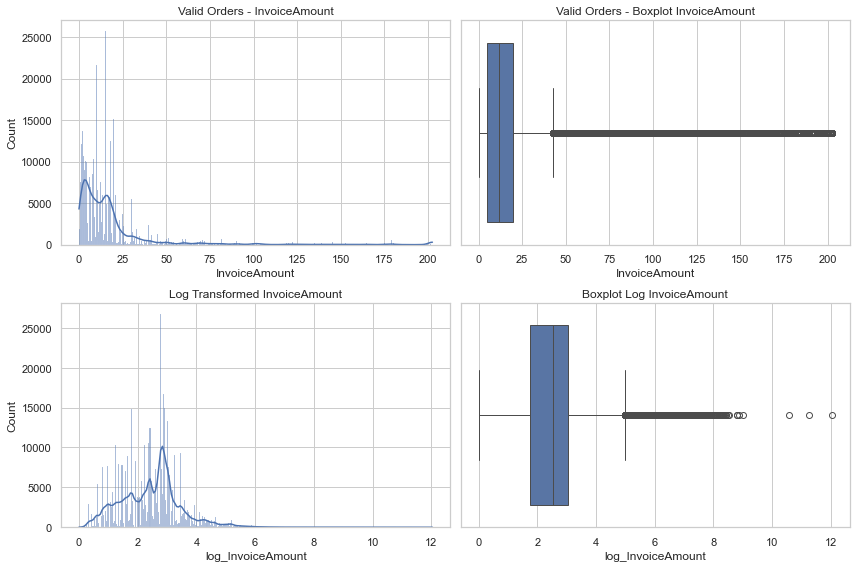

In [17]:
# Visualize distribution before and after transformations (log transformation and capping)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Before transformation
sns.histplot(valid_orders['InvoiceAmount'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Valid Orders - InvoiceAmount')

sns.boxplot(x=valid_orders['InvoiceAmount'], ax=axes[0, 1])
axes[0, 1].set_title('Valid Orders - Boxplot InvoiceAmount')

# After transformation (log)
sns.histplot(valid_orders['log_InvoiceAmount'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Log Transformed InvoiceAmount')

sns.boxplot(x=valid_orders['log_InvoiceAmount'], ax=axes[1, 1])
axes[1, 1].set_title('Boxplot Log InvoiceAmount')

plt.tight_layout()
plt.show()

In [18]:
cleaned_data.shape

(406829, 13)

In [19]:
cleaned_data['is_canceled'].value_counts()

is_canceled
0    397924
1      8905
Name: count, dtype: int64

In [20]:
valid_orders['InvoiceNo'].value_counts().sort_values(ascending=False)

InvoiceNo
576339     542
579196     533
580727     529
578270     442
573576     435
          ... 
C581484      0
C581490      0
C581499      0
C581568      0
C581569      0
Name: count, Length: 22190, dtype: int64

In [21]:
print("Valid Orders Index Range:", valid_orders.index.min(), valid_orders.index.max())
print("Canceled Orders Index Range:", canceled_orders.index.min(), canceled_orders.index.max())
print("Original Data Index Range:", cleaned_data.index.min(), cleaned_data.index.max())

Valid Orders Index Range: 0 397923
Canceled Orders Index Range: 0 8904
Original Data Index Range: 0 397923


The distributions are far from normal distributions for our numerical columns confirming the skewness of 409 and 451 for Quantity and InvoiceAmount respectively. There's still outliers in the dataset. We will transform the values with log-transform to see whether there'll be an improvement.

Our distributions are not not perfect normal distributions but there's a significant improvement in skewness in the numerical columns, outliers have also been reduced.

In [22]:
cleaned_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_canceled,is_free_promo,InvoiceAmount,log_InvoiceAmount,log_Quantity
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,0,15.30,2.791165,1.945910
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0,20.34,3.060583,1.945910
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,0,22.00,3.135494,2.197225
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0,20.34,3.060583,1.945910
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0,20.34,3.060583,1.945910


In [23]:
# Inspection check
print(f'Updated Rows, Columns:', cleaned_data.shape)
cleaned_data.describe(include='number')

Updated Rows, Columns: (406829, 13)


,Quantity,UnitPrice,is_canceled,is_free_promo,InvoiceAmount,log_InvoiceAmount,log_Quantity
count,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000,3.979240e+05,397924.000000
mean,10.677004,3.460471,0.021889,0.000098,18.535517,2.454360e+00,1.917762
std,17.953548,69.315162,0.146321,0.009915,29.311329,1.020615e+00,1.002499
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e-09,0.693147
25%,2.000000,1.250000,0.000000,0.000000,4.200000,1.736951e+00,1.098612
50%,5.000000,1.950000,0.000000,0.000000,11.100000,2.549445e+00,1.945910
75%,12.000000,3.750000,0.000000,0.000000,19.500000,3.034953e+00,2.564949
max,120.000000,38970.000000,1.000000,1.000000,202.500000,1.203452e+01,11.302155


In [24]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 8904
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   InvoiceNo          406829 non-null  category      
 1   StockCode          406829 non-null  category      
 2   Description        406829 non-null  category      
 3   Quantity           406829 non-null  int64         
 4   InvoiceDate        406829 non-null  datetime64[ns]
 5   UnitPrice          406829 non-null  float64       
 6   CustomerID         406829 non-null  category      
 7   Country            406829 non-null  category      
 8   is_canceled        406829 non-null  int32         
 9   is_free_promo      406829 non-null  int32         
 10  InvoiceAmount      406829 non-null  float64       
 11  log_InvoiceAmount  397924 non-null  float64       
 12  log_Quantity       397924 non-null  float64       
dtypes: category(5), datetime64[ns](1), float64(4), int3

In [25]:
# Save cleaned data
cleaned_data.to_pickle('../data/cleaned_data.pkl')

---

## Exploratory Data Analysis

In [26]:
cleaned_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_canceled,is_free_promo,InvoiceAmount,log_InvoiceAmount,log_Quantity
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,0,15.30,2.791165,1.945910
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0,20.34,3.060583,1.945910
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,0,22.00,3.135494,2.197225
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0,20.34,3.060583,1.945910
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0,20.34,3.060583,1.945910


In [27]:
cleaned_data.describe(include='category')

,InvoiceNo,StockCode,Description,CustomerID,Country
count,406829,406829,406829,406829,406829
unique,22190,3684,3877,4372,37
top,576339,85123A,white hanging heart t-light holder,17841,United Kingdom
freq,542,2077,2070,7983,361878


---

## Customer Segmentation   

### Calculate RFM Metrics

In [28]:
# Calculate Reference data
reference_date = cleaned_data['InvoiceDate'].max() + pd.DateOffset(1)
reference_date

Timestamp('2011-12-10 12:50:00')

In [29]:
# Calculate RFM Metrics
rfm = cleaned_data.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (reference_date - x.max()).days),
    Frequency=('InvoiceNo', 'nunique'),
    Monetary=('InvoiceAmount', 'sum')
).reset_index()

# RFM table preview
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,2,202.50
1,12347,2,7,4262.90
2,12348,75,4,1759.74
3,12349,19,1,1660.05
4,12350,310,1,334.40


In [30]:
# Check skewness of RFM metrics
print(rfm[["Recency", "Frequency", "Monetary"]].skew())

Recency       1.249665
Frequency    11.412274
Monetary     20.586448
dtype: float64


In [31]:
# Log-Transform RFM Metrics
rfm[["Recency_log", "Frequency_log", "Monetary_log"]] = rfm[["Recency", "Frequency", "Monetary"]].apply(lambda x: np.log1p(x)).round(2)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Recency_log,Frequency_log,Monetary_log
0,12346,326,2,202.50,5.79,1.10,5.32
1,12347,2,7,4262.90,1.10,2.08,8.36
2,12348,75,4,1759.74,4.33,1.61,7.47
3,12349,19,1,1660.05,3.00,0.69,7.42
4,12350,310,1,334.40,5.74,0.69,5.82


In [32]:
rfm[["Recency_log", "Frequency_log", "Monetary_log"]].skew()

Recency_log     -0.361798
Frequency_log    1.079565
Monetary_log    -0.550620
dtype: float64

### RFM Scoring

We assign higher scores to higher higher frequencies and likewise for higher spending and higher scores to more recent purchases

In [33]:
rfm['Recency_score'] = pd.qcut(rfm['Recency_log'], 5, labels=[5,4,3,2,1])
rfm['Frequency_score'] = pd.qcut(rfm['Frequency_log'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['Monetary_score'] = pd.qcut(rfm['Monetary_log'].rank(method='first'), 5, labels=[1,2,3,4,5])

# Combine scores into one
rfm['RFM_score'] = rfm['Recency_score'].astype(int) + rfm['Frequency_score'].astype(int) + rfm['Monetary_score'].astype(int)

rfm.head()

,CustomerID,Recency,Frequency,Monetary,Recency_log,Frequency_log,Monetary_log,Recency_score,Frequency_score,Monetary_score,RFM_score
0,12346,326,2,202.50,5.79,1.10,5.32,1,2,1,4
1,12347,2,7,4262.90,1.10,2.08,8.36,5,4,5,14
2,12348,75,4,1759.74,4.33,1.61,7.47,2,3,4,9
3,12349,19,1,1660.05,3.00,0.69,7.42,4,1,4,9
4,12350,310,1,334.40,5.74,0.69,5.82,1,1,2,4


### Value Segmentation
We segment our customer into three value segments using quantiles on customers' RFM scores. Customer with the relatively higher scores get assigned to High-Value while the lowest scoring customers get Low-value segment.

In [34]:
value_labels = ['Low-value', 'Mid-value', 'High-value']
rfm['Value_segment'] = pd.qcut(rfm['RFM_score'], q=3, labels=value_labels)
# Preview
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Recency_log,Frequency_log,Monetary_log,Recency_score,Frequency_score,Monetary_score,RFM_score,Value_segment
0,12346,326,2,202.50,5.79,1.10,5.32,1,2,1,4,Low-value
1,12347,2,7,4262.90,1.10,2.08,8.36,5,4,5,14,High-value
2,12348,75,4,1759.74,4.33,1.61,7.47,2,3,4,9,Mid-value
3,12349,19,1,1660.05,3.00,0.69,7.42,4,1,4,9,Mid-value
4,12350,310,1,334.40,5.74,0.69,5.82,1,1,2,4,Low-value


### Behavioral Segmentation
In this section we'll implement clustering technique to get possible distinct groups in the customer base. Our algorithm of choice will be K-Means clustering

**1. Normalize RFM Metrics**

Required of K-Means; distance based algorithms

In [35]:
# Select revelant columns
rfm_data = rfm[['Recency_log', 'Frequency_log', 'Monetary_log']]
# Normalize the data
scaler = MinMaxScaler()
rfm_normalized = scaler.fit_transform(rfm_data)

**2. Determine Optimal Number of Clusters (Elbow Method)**

Identify where the Elbow curve flattens

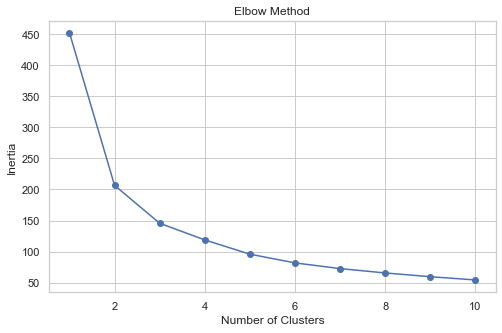

In [36]:
# 1. Elbow Method: (Plot the sum of squared distances (inertia) for different numbers of clustered)
inertia = []
K = range(1, 11)  # Test clusters from 1 to 10
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
# plt.savefig('elbowplot.png')
plt.show()
# OPtimal clusters = 3

3. Perform Clustering

In [37]:
# Perform K-Means clustering
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(rfm_normalized)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
rfm['Cluster'] = kmeans.predict(rfm_normalized) # Evaluation purposes

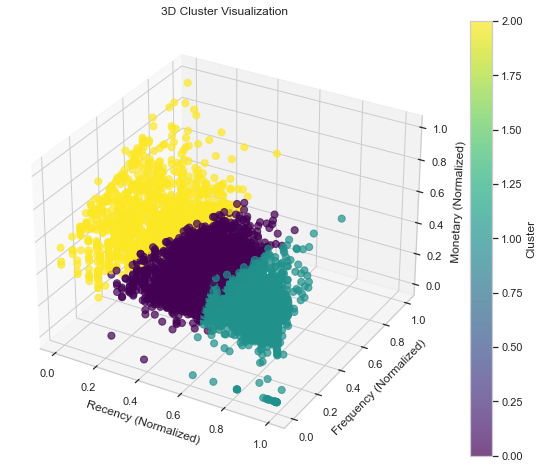

In [38]:
# Ensure that rfm_normalized is converted to a DataFrame
rfm_normalized_df = pd.DataFrame(rfm_normalized, columns=['Recency_score', 'Frequency_score', 'Monetary_score'])
rfm_normalized_df['Cluster'] = rfm['Cluster']  # Add the cluster labels

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    rfm_normalized[:, 0],  # Recency
    rfm_normalized[:, 1],  # Frequency
    rfm_normalized[:, 2],  # Monetary
    c=rfm['Cluster'], cmap='viridis', s=50, alpha=0.7
)

# Labels and title
ax.set_title('3D Cluster Visualization')
ax.set_xlabel('Recency (Normalized)')
ax.set_ylabel('Frequency (Normalized)')
ax.set_zlabel('Monetary (Normalized)')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [39]:
# Compute the Calinski-Harabasz score
ch_score = calinski_harabasz_score(rfm_normalized, labels)

print(f"Calinski-Harabasz Score: {ch_score}")

Calinski-Harabasz Score: 4595.440996343674


4. Analyze the Clusters

- Calculate the average Recency, Frequency, and Monetary values for each cluster to understant behavioral differences between clusters

In [40]:
cluster_profiles = rfm.groupby('Cluster')[['Recency_log', 'Frequency_log', 'Monetary_log']].mean()
print(cluster_profiles)

         Recency_log  Frequency_log  Monetary_log
Cluster                                          
0           3.638551       1.372721      6.527246
1           5.242219       0.974935      5.671446
2           1.962483       2.248725      7.712138


**Interpretation**:
- Cluster 2: **VIP customers** shop most frequently and spend the most
- Cluster 0: **Occasional customers** who shop moderately
- Cluster 1: **At-risk customers** who shop rarely and spend the least.

4. Visualize the Clusters

(i) **Radar Chart for Cluster Profiles**

Compare average RFM metrics across clusters.

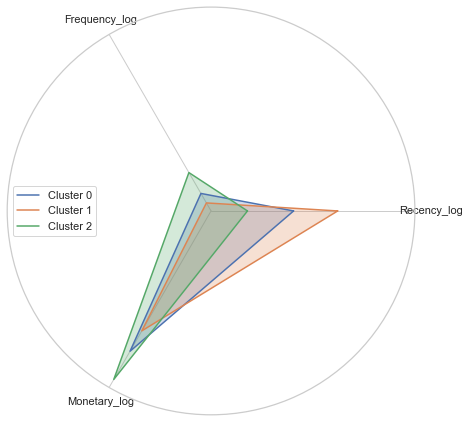

In [41]:
# Prepare data
cluster_avg = cluster_profiles.reset_index().iloc[:, 1:].values
categories = ['Recency_log', 'Frequency_log', 'Monetary_log']
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Plot radar chart
fig, ax = plt.subplots(figsize=(7.5, 7.5), subplot_kw=dict(polar=True))
for i in range(len(cluster_avg)):
    values = cluster_avg[i].tolist()
    values += values[:1]
    ax.plot(angles, values, label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.25)
ax.set_yticks([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.legend(loc='center left')
# plt.savefig('customer_behaviour_clusters.png', dpi=100)
plt.show()

In [42]:
cluster_labels = {
    0: 'Ocassional Customers',
    1: 'At Risk/Hibernating',
    2: 'VIP Customers'    
}
rfm['Customer_segment'] = rfm['Cluster'].map(cluster_labels)

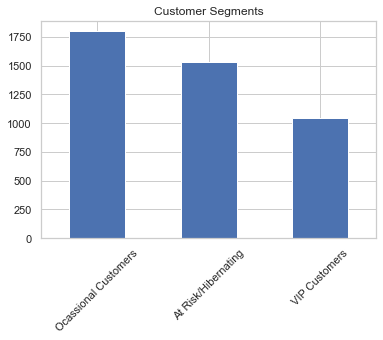

In [116]:
# Validation check
rfm['Customer_segment'].value_counts().plot(kind='bar', title='Customer Segments')
plt.xticks(rotation=45)
plt.show()

In [43]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Recency_log,Frequency_log,Monetary_log,Recency_score,Frequency_score,Monetary_score,RFM_score,Value_segment,Cluster,Customer_segment
0,12346,326,2,202.50,5.79,1.10,5.32,1,2,1,4,Low-value,1,At Risk/Hibernating
1,12347,2,7,4262.90,1.10,2.08,8.36,5,4,5,14,High-value,2,VIP Customers
2,12348,75,4,1759.74,4.33,1.61,7.47,2,3,4,9,Mid-value,0,Ocassional Customers
3,12349,19,1,1660.05,3.00,0.69,7.42,4,1,4,9,Mid-value,0,Ocassional Customers
4,12350,310,1,334.40,5.74,0.69,5.82,1,1,2,4,Low-value,1,At Risk/Hibernating


In [44]:
df_merged = pd.merge(cleaned_data, rfm, on='CustomerID', how='left')

In [45]:
# Save combined DataFrame
df_merged.to_pickle('../data/rfm_data.pkl')

## RFM Analysis

In [75]:
# Load combined DataFrame
rfm_df = pd.read_pickle('../data/rfm_data.pkl')
rfm_df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'is_canceled', 'is_free_promo',
       'InvoiceAmount', 'log_InvoiceAmount', 'log_Quantity', 'Recency',
       'Frequency', 'Monetary', 'Recency_log', 'Frequency_log', 'Monetary_log',
       'Recency_score', 'Frequency_score', 'Monetary_score', 'RFM_score',
       'Value_segment', 'Cluster', 'Customer_segment'],
      dtype='object')

In [76]:
rfm_df[['Recency_log', 'Frequency_log', 'Monetary_log']] = rfm_df[['Recency_log', 'Frequency_log', 'Monetary_log']].astype(int)

How are the segments distributed?

Value_segment
High-value    283090
Mid-value      86003
Low-value      37736
Name: count, dtype: int64


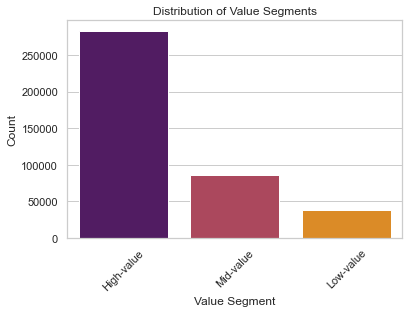

In [57]:
# Value segments
value_counts = rfm_df['Value_segment'].value_counts()
print(value_counts)

# Plot distribution
sns.countplot(data=rfm_df, x='Value_segment', order=value_counts.index, palette="inferno")
plt.title('Distribution of Value Segments')
plt.xlabel('Value Segment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

The High-Value segment comprises the largest proportion, this is a strong indication of a healthy customer base with substantial engagement and loyalty. 

The Low-Value segment is the smallest group accounting for roughly 10% of the customer base. This group may include at-risk customers, requiring re-engagement strategies or further segmentation to identify the most promising for retention efforts.

**Investigating compositions of Value segments by customer segments**.

Group by Value_segment and calculate the percentage of Customer_segment within each value segment

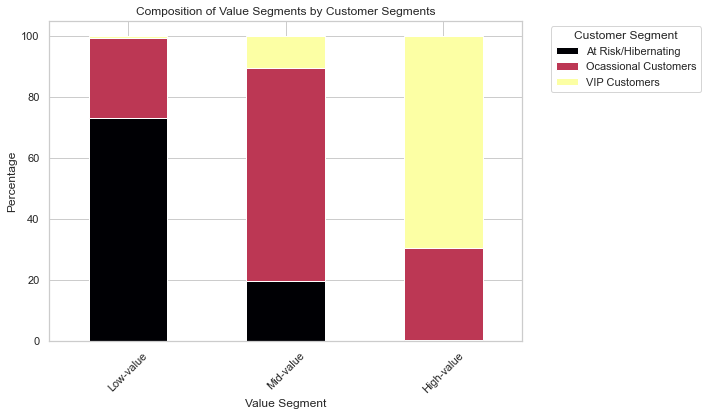

In [58]:
composition = pd.crosstab(
    rfm['Value_segment'], 
    rfm['Customer_segment'], 
    normalize='index'
).mul(100).reset_index()
# print(composition.head())

pivot_data = composition.set_index('Value_segment')
pivot_data.plot(kind='bar', stacked=True, colormap='inferno', figsize=(10, 6))
plt.title('Composition of Value Segments by Customer Segments')
plt.xlabel('Value Segment')
plt.ylabel('Percentage')
plt.legend(title='Customer Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

The stacked bars highlight the different customer-segments proportions in the value segments

**Analyze Revenue contribution by value segment**

*Objective: Understand financial value of each segment*

Value_segment
Low-value      523958.881
Mid-value     1282842.683
High-value    5733984.100
Name: InvoiceAmount, dtype: float64


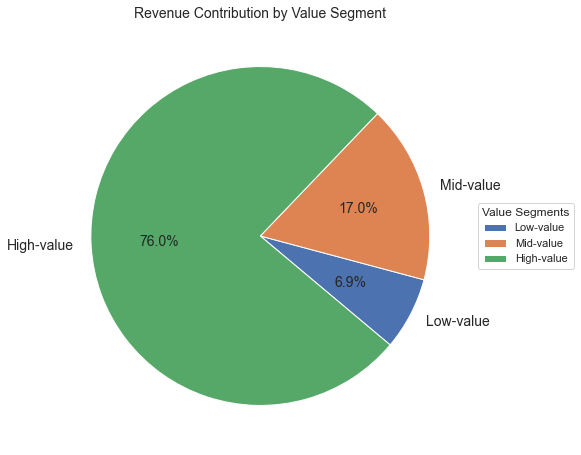

In [59]:
revenue_by_value_seg = rfm_df.groupby('Value_segment')['InvoiceAmount'].sum()
print(revenue_by_value_seg)

# Plot a pie chart
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    revenue_by_value_seg, 
    labels=revenue_by_value_seg.index,  # Add segment labels
    autopct='%1.1f%%',                 # Show percentage
    startangle=320,                    # Rotate for better view
    textprops={'fontsize': 14}         # Adjust text size
)
plt.legend(
    wedges, revenue_by_value_seg.index,
    title="Value Segments",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)
plt.title('Revenue Contribution by Value Segment', fontsize=14)
plt.tight_layout()  # Adjust layout to fit everything
plt.show()

**Customer Engagement Analysis within Value Segments**

In [60]:
engagement_by_value_seg = rfm_df.groupby('Value_segment')['Frequency_log'].mean()
engagement_by_value_seg

Value_segment
Low-value     0.361909
Mid-value     1.011732
High-value    2.366555
Name: Frequency_log, dtype: float64

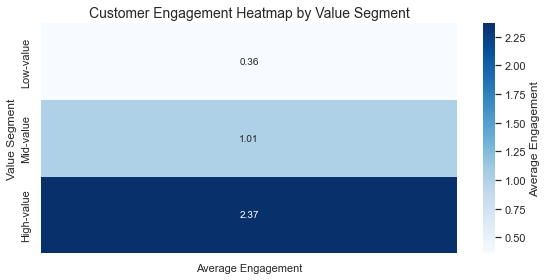

In [61]:
# Convert to DataFrame for Seaborn
engagement_df = engagement_by_value_seg.reset_index()
engagement_df.columns = ['Value Segment', 'Average Engagement']

# Plot a heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(
    engagement_df.pivot_table(index='Value Segment', values='Average Engagement'), 
    annot=True, fmt=".2f", cmap='Blues', cbar_kws={'label': 'Average Engagement'}
)
plt.title('Customer Engagement Heatmap by Value Segment', fontsize=14)
plt.tight_layout()
plt.show()

Higher transformed values indicate higher average engagement frequencies. The Higher-value segment still engages more frequently on average than Mid-value and Low-value.

The back-transformed values provide a clearer sense of the actual engagement levels:

- Low-value: Mean frequency is around 1.38, indicating very infrequent engagement.
- Mid-value: Mean frequency is approximately 3.35, representing moderate engagement.
- High-value: Mean frequency is about 16.52, showing a significantly higher level of engagement.

**Trend Analysis of Value Segment Behavior**

*Objective: Understand how the purchasing behavior of each value segment changes over time.*

In [62]:
rfm_df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'is_canceled', 'is_free_promo',
       'InvoiceAmount', 'log_InvoiceAmount', 'log_Quantity', 'Recency',
       'Frequency', 'Monetary', 'Recency_log', 'Frequency_log', 'Monetary_log',
       'Recency_score', 'Frequency_score', 'Monetary_score', 'RFM_score',
       'Value_segment', 'Cluster', 'Customer_segment'],
      dtype='object')

In [63]:
rfm_df['InvoiceDate'] = pd.to_datetime(rfm_df['InvoiceDate'])
rfm_df.set_index('InvoiceDate', inplace=True)
trend_by_segment = rfm_df.groupby(['Value_segment']).resample('M')['InvoiceAmount'].sum().unstack()
# trend_by_segment

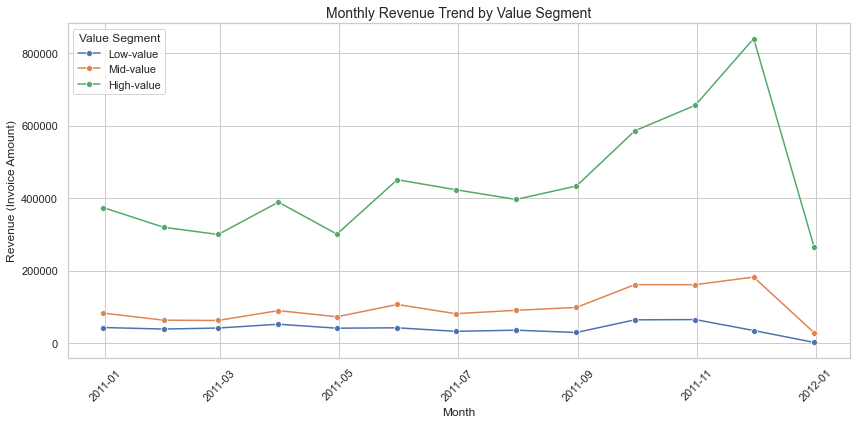

In [64]:
# Prepare data for seaborn
trend_df = trend_by_segment.stack().reset_index()
trend_df.columns = ['Value Segment', 'Month', 'Invoice Amount']

# Plot line plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=trend_df,
    x='Month', y='Invoice Amount', hue='Value Segment', marker='o'
)

# Add titles and labels
plt.title('Monthly Revenue Trend by Value Segment', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Revenue (Invoice Amount)', fontsize=12)

# Improve date readability
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

**Churn Risk and Retention Analysis**

*Objective: Evaluate the churn risk for each value segment*

In [65]:
churn_by_value_segment = rfm_df.groupby('Value_segment')['Recency_log'].mean()  # Longer recency = higher churn risk
churn_by_value_segment

Value_segment
Low-value     4.309015
Mid-value     3.359929
High-value    1.721361
Name: Recency_log, dtype: float64

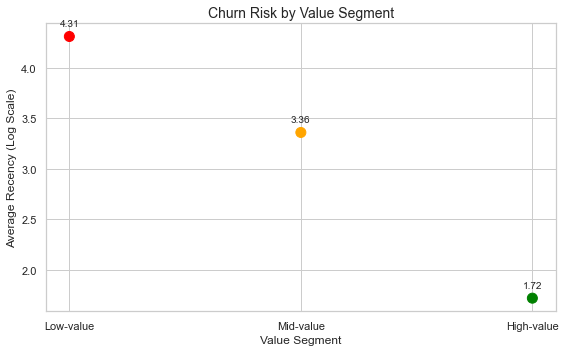

In [66]:
# Plot a dot plot
plt.figure(figsize=(8, 5))
plt.scatter(churn_by_value_segment.index, churn_by_value_segment, color=['red', 'orange', 'green'], s=100)

# Add labels and title
plt.ylabel('Average Recency (Log Scale)', fontsize=12)
plt.xlabel('Value Segment', fontsize=12)
plt.title('Churn Risk by Value Segment', fontsize=14)

# Add values near the dots
for index, value in enumerate(churn_by_value_segment):
    plt.text(index, value + 0.1, f'{value:.2f}', ha='center', fontsize=10)

# Display the chart
plt.tight_layout()
plt.show()

**Cross-Sell and Upsell Potential by Value Segment**

*Objective*: Identify potential for cross-selling and upselling within value segments.

*Approach*:
For each value segment, examine which products are frequently purchased together or which higher-value products can be suggested

In [67]:
cross_sell_potential = rfm_df.groupby(['Value_segment', 'Description'])['InvoiceAmount'].sum().unstack()
cross_sell_potential

Description,10 colour spaceboy pen,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 hanging eggs hand painted,12 ivory rose peg place settings,12 message cards with envelopes,12 pencil small tube woodland,12 pencils small tube red retrospot,12 pencils small tube skull,...,zinc star t-light holder,zinc sweetheart soap dish,zinc sweetheart wire letter rack,zinc t-light holder star large,zinc t-light holder stars large,zinc t-light holder stars small,zinc top 2 door wooden shelf,zinc willie winkie candle stick,zinc wire kitchen organiser,zinc wire sweetheart letter tray
Value_segment,,,,,,,,,,,,,,,,,,,,,
Low-value,494.70,101.4,52.80,191.25,0.00,41.25,375.75,273.00,266.50,268.45,...,52.50,0.00,67.50,181.45,0.0,331.48,33.9,221.00,0.0,11.25
Mid-value,1116.05,230.1,74.25,165.75,27.04,175.00,709.05,402.35,627.25,489.45,...,370.00,29.88,206.25,462.49,0.0,763.53,0.0,324.70,57.4,47.50
High-value,3593.56,1041.8,412.50,1068.27,60.32,720.00,1505.40,1858.40,2902.05,3298.40,...,852.02,77.02,649.88,1252.60,22.8,2784.97,135.6,1631.25,99.4,194.49


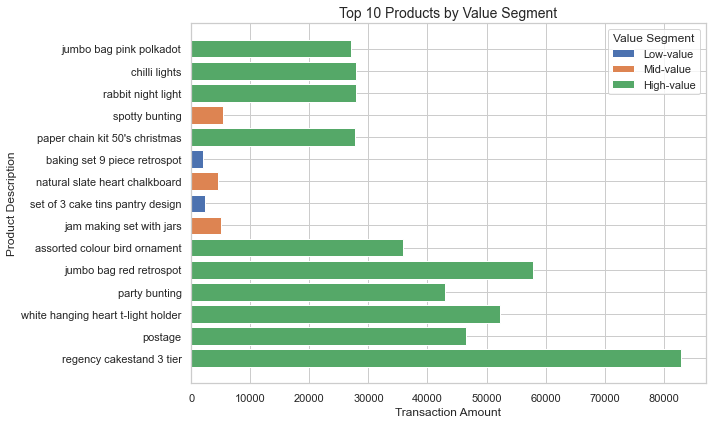

In [68]:
# Aggregate top 10 products by value segment
top_products_by_segment = cross_sell_potential.sum(axis=1).nlargest(10)

plt.figure(figsize=(10, 6))
for segment in cross_sell_potential.index:
    top_products = cross_sell_potential.loc[segment].nlargest(10)  # Top 10 products for the segment
    plt.barh(top_products.index, top_products.values, label=segment)

# Add labels and legend
plt.xlabel('Transaction Amount', fontsize=12)
plt.ylabel('Product Description', fontsize=12)
plt.title('Top 10 Products by Value Segment', fontsize=14)
plt.legend(title="Value Segment", loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()

**Geographic and Demographic Insights by Value Segment**

*Objective:* 

Examine how location (Country) and demographic factors (e.g., age, gender, etc.) influence the purchasing behavior of each value segment.

*Approach:*

Look at the geographical distribution of each segment.
For example, VIP customers may be more concentrated in certain regions or countries.

In [69]:
geographic_by_segment = rfm_df.groupby(['Country', 'Value_segment'])['InvoiceAmount'].sum().unstack()
geographic_by_segment.head()

Value_segment,Low-value,Mid-value,High-value
Country,,,
Australia,401.90,4806.05,96318.58
Austria,1800.14,7603.26,437.98
Bahrain,548.40,0.00,0.00
Belgium,2085.25,12615.54,26495.55
Brazil,1143.60,0.00,0.00


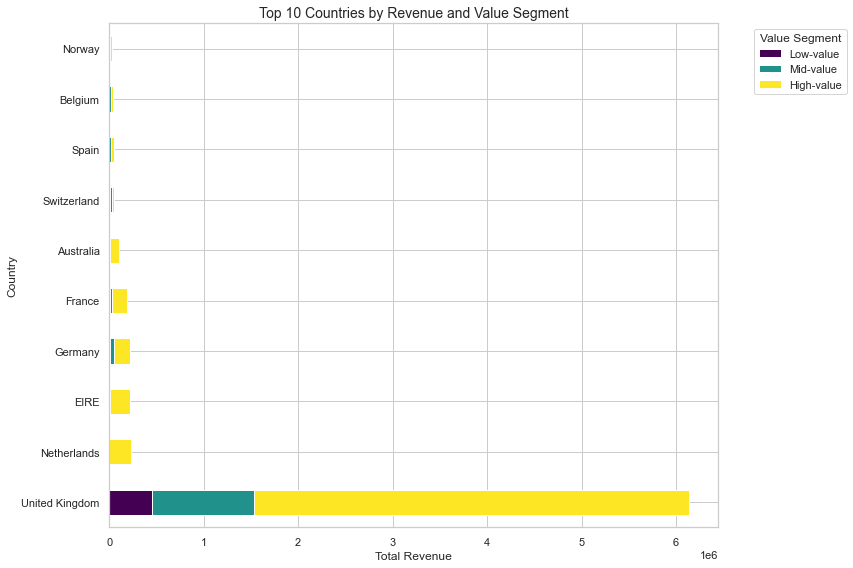

In [70]:
# Select top 10 countries
top_countries = geographic_by_segment.sum(axis=1).nlargest(10).index
stacked_data = geographic_by_segment.loc[top_countries]

# Plot a stacked bar chart
stacked_data.plot(kind='barh', stacked=True, figsize=(12, 8), colormap='viridis')

# Add labels and title
plt.xlabel('Total Revenue', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Top 10 Countries by Revenue and Value Segment', fontsize=14)
plt.legend(title='Value Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the chart
plt.show()

9. **Marketing Effectiveness by Segment**

*Objective:* 

Evaluate how effective different marketing campaigns are for each segment.

*Approach*:

Compare conversion rates, response to promotions, and discount redemption rates across value segments.
Flow to Next: Allows the retailer to refine their marketing strategies for each value segment based on the campaign's performance.

### **Analyze Value Segments Over Time**

In [71]:
# Extract year and month for analysis
rfm_df.index = pd.to_datetime(rfm_df.index) # since rfm_df has InvoiceDate as the index 
rfm_df['YearMonth'] = rfm_df.index.to_period('M')
rfm_df[['YearMonth']].head()

# Aggregate RFM metrics by time
rfm_trends = rfm_df.groupby(['YearMonth', 'Value_segment'])[['Recency_log', 'Frequency_log', 'Monetary_log']].mean().reset_index()

rfm_trends.head()

,YearMonth,Value_segment,Recency_log,Frequency_log,Monetary_log
0,2010-12,Low-value,4.944867,0.463607,5.175177
1,2010-12,Mid-value,3.939821,1.257786,6.499912
2,2010-12,High-value,1.671833,2.460395,8.115356
3,2011-01,Low-value,4.956924,0.431965,5.491143
4,2011-01,Mid-value,4.025101,1.134502,6.614729


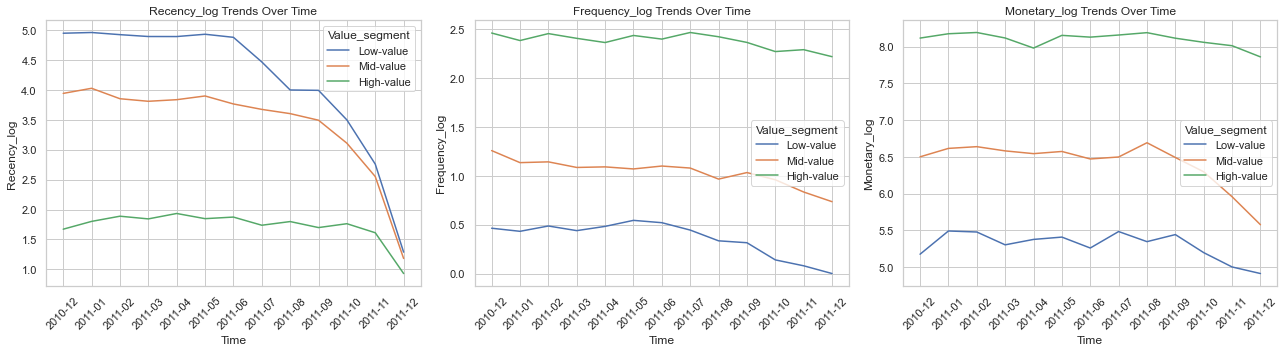

In [72]:
# Convert YearMonth to string for plotting
rfm_trends['YearMonth'] = rfm_trends['YearMonth'].astype(str)
# Plot trends for each metric
metrics =['Recency_log', 'Frequency_log', 'Monetary_log']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics):
    sns.lineplot(data=rfm_trends, x='YearMonth', y=metric, hue='Value_segment', ax=axes[i])
    axes[i].set_title(f'{metric} Trends Over Time')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Analyze Customer Value-Segment Transitions Over Time**

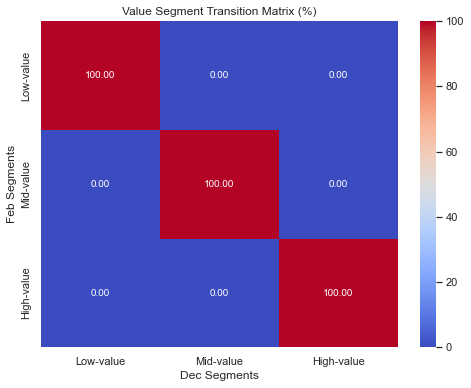

In [73]:
# Create snapshots for two time periods
snapshot_1 = rfm_df[rfm_df['YearMonth'] == '2010-12'][['CustomerID', 'Value_segment']].rename(columns={'Value_segment': 'Segment_Dec'})
snapshot_2 = rfm_df[rfm_df['YearMonth'] == '2011-06'][['CustomerID', 'Value_segment']].rename(columns={'Value_segment': 'Segment_Feb'})

# Merge snapshots to observe transitions
transitions = snapshot_1.merge(snapshot_2, on='CustomerID', how='inner')

# Generate transition matrix
transition_matrix = pd.crosstab(transitions['Segment_Dec'], transitions['Segment_Feb'], normalize='index') * 100

# Visualize the transition matrix
plt.figure(figsize=(8, 6))
sns.heatmap(transition_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Value Segment Transition Matrix (%)')
plt.xlabel('Dec Segments')
plt.ylabel('Feb Segments')
plt.show()


**Analyzing Proportion of Each Segment Over Time**

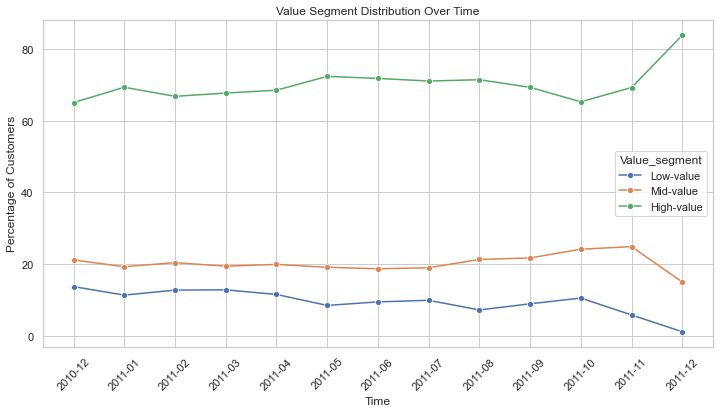

In [74]:
# Converting period column to string for plotting
rfm_df['YearMonth'] = rfm_df['YearMonth'].astype(str)
# Create a crosstab of Value_segment by YearMonth
value_segment_crosstab = pd.crosstab(
    rfm_df['YearMonth'], 
    rfm_df['Value_segment'], 
    normalize='index'  # Normalize within each time period (row-wise)
).mul(100)  # Convert proportions to percentages

# Reset index for plotting
value_segment_crosstab = value_segment_crosstab.reset_index()

# Melt the DataFrame for Seaborn compatibility
segment_distribution = value_segment_crosstab.melt(
    id_vars='YearMonth', 
    var_name='Value_segment', 
    value_name='Percentage'
)

# Plot the segment distribution over time
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=segment_distribution, 
    x='YearMonth', y='Percentage', hue='Value_segment', marker='o'
)
plt.title('Value Segment Distribution Over Time')
plt.xlabel('Time')
plt.ylabel('Percentage of Customers')
plt.xticks(rotation=45)
plt.show()

## **Customer Segment Analysis**

**1. Revenue Contribution by Customer Segment**

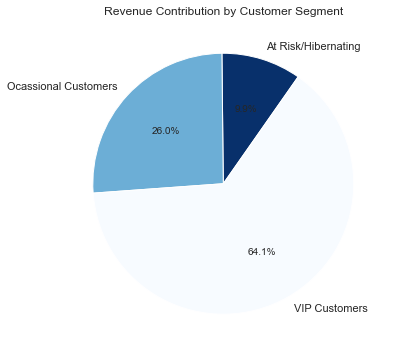

In [93]:
# Reset index to have InvoiceDate as column
# rfm_df.reset_index(inplace=True)

# Group data by Customer Segment to calculate revenue
revenue_by_segment = rfm_df.groupby('Customer_segment')['InvoiceAmount'].sum()

# Plot a pie chart
plt.figure(figsize=(8, 6))
revenue_by_segment.plot(kind='pie', autopct='%1.1f%%', startangle=55, cmap='Blues_r', legend=False)
plt.title('Revenue Contribution by Customer Segment')
plt.ylabel('')  # Remove default y-axis label
plt.show()

**2. Customer Rentention and Churn Risk**

Analyze customer retention and identify high-risk segments using `Recency`

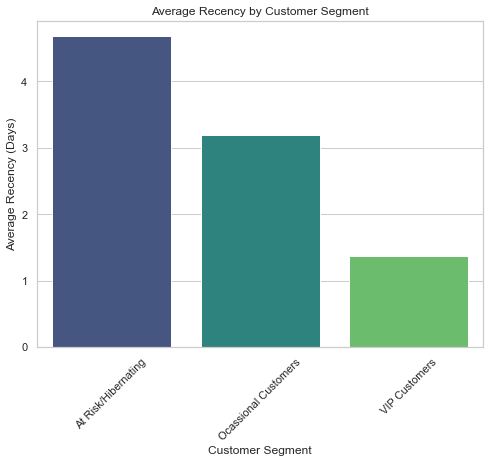

In [76]:
# Calculate average recency for each segment
recency_by_segment = rfm_df.groupby('Customer_segment')['Recency_log'].mean()

# Bar plot to visualize
plt.figure(figsize=(8, 6))
sns.barplot(x=recency_by_segment.index, y=recency_by_segment.values, palette='viridis')
plt.title('Average Recency by Customer Segment')
plt.ylabel('Average Recency (Days)')
plt.xlabel('Customer Segment')
plt.xticks(rotation=45)
plt.show()

In [77]:
# recency_by_segment.sort_values().plot(kind='barh', color='skyblue', figsize=(8, 6))
# plt.title('Average Recency by Customer Segment')
# plt.xlabel('Average Recency (Days)')
# plt.ylabel('Customer Segment')
# plt.show()

**3. Product Preference by Segment**

In [79]:
# # Select one segment (example: 'VIP Customers')
# cluster_0 = top_products_by_segment[top_products_by_segment['Customer_segment'] == 'VIP Customers']

# # Plot horizontal bar graph
# plt.barh(cluster_0['Description'], cluster_0['InvoiceAmount'], color='cornflowerblue')
# plt.title('Top 3 Products for VIP Customers')
# plt.xlabel('Revenue')
# plt.ylabel('Products')
# plt.gca().invert_yaxis()  # Optional: Invert y-axis to display the highest revenue at the top
# # plt.tight_layout()  # Adjust layout to avoid overlap
# plt.show()

In [ ]:
sns.catplot(
    data=top_products_by_segment, kind='bar',
    x='Customer_segment', y='TransactionAmount', hue='Description', palette='Set2', height=6, aspect=2
)
plt.title('Top Products by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Revenue')
plt.show()


**4. Geographics Insights**

Examine Segment behavior across countries

In [ ]:
# Group by Country and Segment to find revenue contribution
geo_segment_data = rfm_df.groupby(['Country', 'Customer_segment'])['TransactionAmount'].sum().unstack()

# Plot stacked bar chart
geo_segment_data.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab10')
plt.title('Geographic Revenue by Customer Segment')
plt.xlabel('Country')
plt.ylabel('Revenue')
plt.xticks(rotation=90)
plt.legend(title='Customer Segment')
plt.show()

In [ ]:
# Geographical Heatmap
import plotly.express as px

geo_summary = rfm_df.groupby('Country')['TransactionAmount'].sum().reset_index()
fig = px.choropleth(
    geo_summary, locations='Country', locationmode='country names',
    color='TransactionAmount', color_continuous_scale='Blues',
    title='Revenue by Country'
)
fig.show()

**5. Purchase Patterns Over Time**

In [ ]:
# Group data by YearMonth and Segment to analyze trends
monthly_trend = rfm_df.groupby(['YearMonth', 'Customer_segment'])['TransactionAmount'].sum().unstack()

# Plot line chart
plt.figure(figsize=(10, 6))
for column in monthly_trend:
    plt.plot(monthly_trend.index, monthly_trend[column], label=column)
plt.title('Monthly Purchase Trends by Customer Segment')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.legend(title='Customer Segment')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Highlight seasonality using Area charts
monthly_trend.plot(kind='area', stacked=True, colormap='viridis', figsize=(10, 6), alpha=0.8)
plt.title('Monthly Revenue Trends by Customer Segment')
plt.xlabel('Year-Month')
plt.ylabel('Revenue')
plt.show()

**6. Customer Lifetime Value**

In [ ]:
# Calculate average CLV for each segment
clv_by_segment = rfm_df.groupby('Customer_segment')['Monetary_log'].mean()

# Plot CLV distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=clv_by_segment.index, y=clv_by_segment.values, palette='coolwarm')
plt.title('Customer Lifetime Value by Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Average CLV')
plt.show()

**7. Cross-sell and Upsell Opportunities**

Uncover patterns in product purchases for cross-sell opportunities

In [ ]:
# # Generate a basket matrix
# basket = rfm_df.groupby(['CustomerID', 'Description'])['Quantity'].sum().unstack().fillna(0)
# basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# # Apply apriori algorithm
# frequent_itemsets = apriori(basket, min_support=0.05, use_colnames=True)
# rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.5)

# # Display top 5 rules
# print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

In [ ]:
# from mlxtend.frequent_patterns import fpgrowth, association_rules

# # Generate the basket matrix
# basket = rfm_df.groupby(['CustomerID', 'Description'])['Quantity'].sum().unstack().fillna(0)
# basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# # Apply fp-growth
# frequent_itemsets = fpgrowth(basket, min_support=0.05, use_colnames=True)

# # Generate association rules
# rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.5)

# # Display the top 5 rules
# print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

In [ ]:
# # Cross-selling patterns
# G = nx.from_pandas_edgelist(rules, source='antecedents', target='consequents', edge_attr='lift')
# plt.figure(figsize=(10, 8))
# nx.draw(G, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_color='black')
# plt.title('Cross-Sell Opportunities')
# plt.show()

**10. Final Recommendations for Action**

*Objective:* 

Provide actionable insights based on the combined analysis.

*Approach:*

Use the findings to create a segment-based marketing strategy, targeting each value segment with appropriate strategies like loyalty rewards, re-engagement campaigns, or personalized offers.
Flow to Next: This can result in ongoing tracking of performance, where you'll reanalyze your value segments periodically to refine strategies.